In [1]:
# feedparser is a python library to parse python feeds
import feedparser

In [2]:
# reading guardian rss feed for businesses
guardianSource = "https://www.theguardian.com/us-news/us-politics/rss"
guardianFeed = feedparser.parse(guardianSource)

# reading dailymail rss feed for businesses
dailymailSource = "https://www.dailymail.co.uk/news/us_election_polls/index.rss"
dailymailFeed = feedparser.parse(dailymailSource)




In [3]:
# reading entries from rss feed
guaedianEntries = guardianFeed.entries

In [4]:
dailymailEntries = dailymailFeed.entries

In [5]:
# connecting to mongo Database

from pymongo import MongoClient


# key credential for mongo cluster
MONGO_CLIENT_KEY = "you wish"

# using MongoClient  Credentials & instance   to connect to 
client = MongoClient(MONGO_CLIENT_KEY)
db = client.SentimantAnalysis

dailyMailCol = db.dailyMail
guardiancol = db.guardian

In [6]:
# parsing dailymail entries and saving it to mongo
for article in dailymailEntries:
    # description of article     
    desc = article['summary_detail']['value']
    # title of the entry
    title = article['title']
    # final string which contains description and headline to get a better polarity result
    completeString = title + ' ' + desc

    dailyMailCol.insert_one({
        'value': completeString
    })

In [7]:
# html parser for strings

from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


In [8]:
# parsing guardian entries and saving it to mongo
for article in guaedianEntries:
    # description of article     
    descInit = article['description']
    
    #clean html elements
    descCleanHTML = strip_tags(descInit)

    # final desc
    desc = descCleanHTML.replace('Continue reading...', '')
    # title of the entry
    title = article['title']
    # final string which contains description and headline to get a better polarity result
    completeString = title + ' ' + desc
    guardiancol.insert_one({
        'value': completeString
    })

In [9]:
# reading data from collectioon and getting words using textblob
from textblob import TextBlob as tb

# for anlysing data
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

# cleaning data removing tags
def cleanData(str):
    dailymailFilterWords = list()
    blob = tb(str)
    filterTags = list(['VBD', 'DT','TO', 'CD', 'CC', 'IN', 'VBZ', 'VB'])
    for word,tag in blob.tags:
#         print(word, tag)
        if (tag not in filterTags): 
            dailymailFilterWords.append(word.lemmatize())
    return " ".join(dailymailFilterWords)

# get data analysis using vader
def articleAnalysisVader(cursor):
    vaderSent = []
    for document in cursor:

        value = document['value']

        #cleanin value from doc     
        cleanValue = cleanData(value)

        #vader sentiment
        vs = analyser.polarity_scores(cleanValue)

        documentAnalysis = dict({'value': cleanValue})
        documentAnalysis.update(vs)
        vaderSent.append(documentAnalysis)
    return vaderSent

def findSentiment(vaderSentiment):
    Sentiment = []
    for index,row in vaderSentiment.iterrows():
        if row['vader_compound'] < -0.5 and row['vader_neg']-row['vader_pos'] > 0 :
            Sentiment.append('Negative')
        elif row['vader_compound'] > 0.5 and row['vader_pos']-row['vader_neg'] > 0 :
            Sentiment.append('Positive')
        else:
            Sentiment.append('Neutral')
    return Sentiment

In [10]:
# sentiment analysis of all words
def wordAnalysisVader(cursor):
    
    vaderSent = []
    woordlist = []
    for document in cursor:
        value = document['value']
        
        #cleanin value from doc     
        cleanValue = cleanData(value)
        
        #getting woords froom senetence         
        words = tb(cleanValue).words

        for word in words:
            # not doing a word again             
            if word not in woordlist:
                documentAnalysis = dict()
                
                #sentiment using textblob
                wordPol = tb(word).sentiment.polarity
                
                if (wordPol !=0):
                    documentAnalysis = {'word': word, 'polarity': wordPol}
                    vaderSent.append(documentAnalysis)
                
                woordlist.append(word)
            
    return vaderSent

In [11]:
import pandas as pd
import time


import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# sentiment analysis for daily mail

# get data from database
dailyMailCursor = dailyMailCol.find({})



# bulild a df for vader analysis
dailymailSent = pd.DataFrame(articleAnalysisVader(dailyMailCursor))
dailymailSent.columns = ['article', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']    

# categorising sentiment as positive/negative/nwutral
sentiment = findSentiment(dailymailSent)
dailymailSent['vader_sentiment'] = sentiment


dailymailText = ' '.join(dailymailSent['article'].tolist())

# getting excel for visualization
dailymailSent.to_excel("dailmailSent.xlsx")



dailyMailCursor.rewind()

# print(dailymailDF)
# sentiment analysis of world with count
dailymailWordSent = wordAnalysisVader(dailyMailCursor)
dailmailWordSentDF = pd.DataFrame(dailymailWordSent)

# saving sentoment to woords
dailmailWordSentDF.to_excel("dailmailWordSent.xlsx")




[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kanavarora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kanavarora/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kanavarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


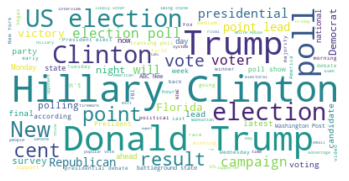

In [12]:
# woord cloud for dailymail
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# for plotting on screen
import matplotlib.pyplot as plt

dailymailWordClould = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(dailymailText)

plt.imshow(dailymailWordClould, interpolation='bilinear')
plt.axis("off")
plt.show()


In [13]:
# get data from database
# sentiment analysis for guardian
gurdianCursor = guardiancol.find({})

# bulild a df for vader analysis
guardianSent = pd.DataFrame(articleAnalysisVader(gurdianCursor))
guardianSent.columns = ['article', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']    

# categorising sentiment as positive/negative/nwutral
sentiment = findSentiment(guardianSent)
guardianSent['vader_sentiment'] = sentiment

# gettting article text
guardianText = ' '.join(guardianSent['article'].tolist())

# getting excel for visualization
guardianSent.to_excel("guardianSent.xlsx")

gurdianCursor.rewind()

# print(dailymailDF)
# sentiment analysis of world with count
guardianWordSent = wordAnalysisVader(gurdianCursor)
guardianWordSentDF = pd.DataFrame(guardianWordSent)

# saving sentoment to woords
guardianWordSentDF.to_excel("guardianWordSent.xlsx")



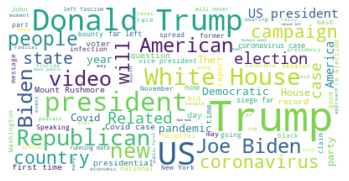

In [14]:
# word cloud guardian

guardianWordClould = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(guardianText)

plt.imshow(guardianWordClould, interpolation='bilinear')
plt.axis("off")
plt.show()